In [98]:
!pip install bio

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm, trange
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, normalize
import os
%matplotlib inline

In [100]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [101]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [102]:
# settings

data_path = "drive/My Drive/CS582/topic1-data/"
batch_size = 100
validation_ratio = 0.2

In [103]:
train_data_path = data_path + "BATF/BATF-train-sequence.fa"
test_data_path = data_path + "BATF/BATF-test-sequence.fa"
train_label_path = data_path + "BATF/BATF-train.bed"
test_label_path = data_path + "BATF/BATF-test.bed"

In [104]:
def get_tf_list(data_path):
  tf_list = os.listdir(data_path)
  for tf in tf_list:
      if not os.path.isdir(data_path+tf):
          tf_list.remove(tf)
  return tf_list

In [105]:
def one_hot_encoder(sequence):
   encoder = OneHotEncoder(sparse=False, dtype=int)
   encoder.fit([['A'], ['T'], ['C'], ['G']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [130]:
class TFBindingDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TFBindingDataset, self).__init__()
        self.X = [np.array(list(record.seq.__str__().upper())).reshape(-1, 1) for record in SeqIO.parse(data_path, "fasta")]
        self.X = np.array([one_hot_encoder(data) for data in self.X]).astype('float32')
        shape = self.X.shape
        self.X = torch.as_tensor(self.X.reshape(shape[0], 1, shape[1], shape[2]))
        self.y = pd.read_csv(label_path, sep='\t', header=None).drop(labels=0, axis=1).to_numpy(dtype=float)

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

In [107]:
tf_list = get_tf_list(data_path)

In [108]:
train_set = TFBindingDataset(train_data_path, train_label_path) 
test_set = TFBindingDataset(test_data_path, test_label_path)  
train_set, val_set = random_split(train_set, [int(len(train_set)*(1 - validation_ratio)), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

In [109]:
for data in train_loader:
    X, y = data 
    print(X.shape)
    print(y.shape)
    break

torch.Size([100, 1, 501, 4])
torch.Size([100, 1])


In [110]:
def plot_binding_histogram(data_loader, data_name):
    binding_values = []
    for data in data_loader:
        _, y = data
        binding_values.extend(torch.reshape(y, (-1,))) 
    binding_values = torch.stack(binding_values)
    plt.figure(figsize=(7,7))
    plt.title(data_name + " Bindings Histogram")
    plt.xlabel("Binding Value")
    plt.ylabel("Count")
    plt.hist(binding_values, bins=40)

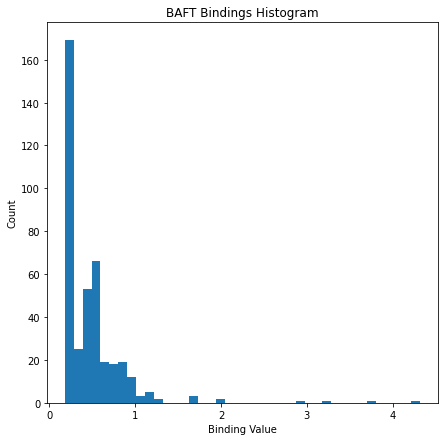

In [111]:
plot_binding_histogram(test_loader, "BAFT")

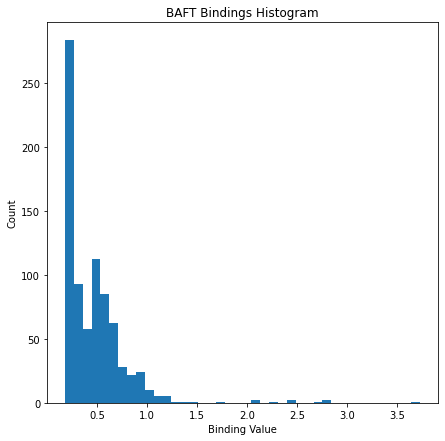

In [112]:
plot_binding_histogram(train_loader, "BAFT")

In [113]:
class BindingPredictionCNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=10, kernel_size=(20, 4), stride=1)
        self.conv2 = Conv1d(in_channels=10, out_channels=20, kernel_size=14, stride=1)
        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)

        self.fc1 = Linear(in_features=30*105, out_features=1500)
        self.fc2 = Linear(in_features=1500, out_features=250)
        self.out = Linear(in_features=250, out_features=1)

    def forward(self, x):
        x = F.relu((self.conv1(x)).squeeze())
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [126]:
model = BindingPredictionCNN()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


In [127]:
def train(net, train_loader, val_loader, optimizer, criterion, epoch_num=100):
    train_log = []
    val_log = []

    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):        
            x, y = x.to(device), y.to(device)        
            optimizer.zero_grad()
            outputs = net(x)
            loss = criterion(outputs.float(), y.float())      
            loss.backward()                
            optimizer.step()        
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        print('============ epoch %d =============' %epoch)
        print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')

        test_loss = []
        net.eval()
        with torch.no_grad():                
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):         
                x, y = x.to(device), y.to(device)        
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())            
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss)) 
        print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
    return train_log, val_log

In [128]:
train_log, val_log = train(model, train_loader, val_loader, optimizer, criterion)

Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 1 =============
train loss: 1.841

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.484

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 2 =============
train loss: 1.120

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.336

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 3 =============
train loss: 1.073

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.303

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 4 =============
train loss: 0.965

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.330

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 5 =============
train loss: 0.951

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.298

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 6 =============
train loss: 0.930

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.317

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 7 =============
train loss: 0.912

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.299

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 8 =============
train loss: 0.911

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.306

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 9 =============
train loss: 0.888

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.295

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 10 =============
train loss: 0.890

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.294

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 11 =============
train loss: 0.891

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.311

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 12 =============
train loss: 0.844

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.296

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 13 =============
train loss: 0.805

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.293

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 14 =============
train loss: 0.741

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.294

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 15 =============
train loss: 0.674

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.301

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 16 =============
train loss: 0.562

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.342

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 17 =============
train loss: 0.460

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.324

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 18 =============
train loss: 0.334

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.375

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 19 =============
train loss: 0.231

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.344

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 20 =============
train loss: 0.147

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 21 =============
train loss: 0.091

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.365

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 22 =============
train loss: 0.061

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 23 =============
train loss: 0.048

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 24 =============
train loss: 0.034

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.376

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 25 =============
train loss: 0.023

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.378

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 26 =============
train loss: 0.016

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.377

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 27 =============
train loss: 0.010

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 28 =============
train loss: 0.008

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.377

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 29 =============
train loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 30 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.374

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 31 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.372

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 32 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 33 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.372

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 34 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 35 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.372

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 36 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 37 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 38 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 39 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 40 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 41 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 42 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 43 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 44 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 45 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 46 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 47 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 48 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 49 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 50 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 51 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 52 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 53 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 54 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 55 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 56 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 57 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 58 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 59 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 60 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.366

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 61 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.371

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 62 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.365

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 63 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.366

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 64 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.372

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 65 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.362

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 66 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 67 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.366

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 68 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.363

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 69 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 70 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.365

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 71 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 72 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 73 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 74 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 75 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.360

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 76 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 77 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 78 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.363

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 79 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 80 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 81 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 82 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 83 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.365

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 84 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 85 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.363

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 86 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.363

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 87 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.370

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 88 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.361

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 89 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 90 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.364

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 91 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.357

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 92 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 93 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.357

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 94 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.369

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 95 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.359

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 96 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.368

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 97 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.355

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 98 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.367

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 99 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.360

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 100 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.365

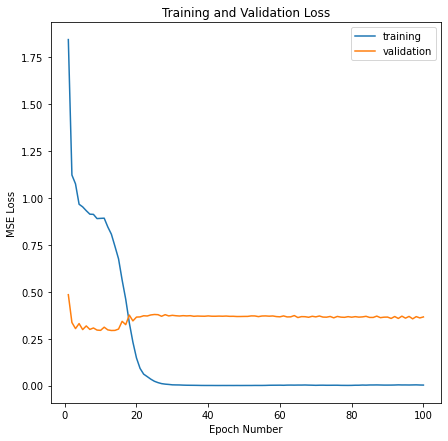

In [129]:
plot_loss(train_log, val_log, 100)

In [118]:
def test(net, test_loader):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():                
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):         
            x_input, labels = x_input.to(device), labels.to(device)        
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

In [119]:
def plot_loss(train_log, val_log, epoch_num):
    plt.figure(figsize=(7,7))
    plt.plot(range(1, epoch_num + 1), train_log, color='C0', label='training')
    plt.plot(range(1, epoch_num + 1), val_log, color='C1', label='validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('MSE Loss')
    plt.legend(loc='best')
    plt.show()

In [120]:
y_true, y_pred = test(model, test_loader)

Test :   0%|          | 0/4 [00:00<?, ?it/s]

In [121]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

Test MSE:  0.23955111


# Classification

In [135]:
binding_threshold = np.median(binding_values)

In [133]:
binding_values = []
for data in train_loader:
    _, y = data
    binding_values.extend(torch.reshape(y, (-1,))) 
for data in val_loader:
    _, y = data
    binding_values.extend(torch.reshape(y, (-1,))) 
binding_values = torch.stack(binding_values)

In [136]:
binding_threshold

0.386426

In [137]:
y_pred_binary = (y_pred > binding_threshold) * 1
y_true_binary = (y_true > binding_threshold) * 1

In [138]:
def classification_statistics(y_true_binary, y_pred_binary):
    tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print(confusion_matrix(y_true_binary, y_pred_binary))
    print(classification_report(y_true_binary, y_pred_binary))
    print("=== Statistics ===")
    print("Test Accuracy: %.3f" % accuracy)
    print("Test Sensitivity: %.3f" % sensitivity)
    print("Test Specificity: %.3f" % specificity)
    print("Test F1-Score: %.3f" % f1_score)

In [139]:
classification_statistics(y_true_binary, y_pred_binary)

[[ 80 114]
 [ 94 112]]
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       194
           1       0.50      0.54      0.52       206

    accuracy                           0.48       400
   macro avg       0.48      0.48      0.48       400
weighted avg       0.48      0.48      0.48       400

=== Statistics ===
Test Accuracy: 0.480
Test Sensitivity: 0.544
Test Specificity: 0.412
Test F1-Score: 0.519


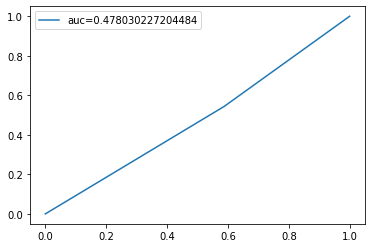

In [148]:
fpr, tpr, _ = roc_curve(y_true_binary,  y_pred_binary)
auc = roc_auc_score(y_true_binary, y_pred_binary)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend()
plt.show()